<a href="https://colab.research.google.com/github/RokelisK123/gilusis/blob/main/OneImageCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [1]:
#@title Required imports

import tensorflow as tf
import tensorflow_hub as hub
import requests
from io import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
from IPython.display import HTML
import math
import json
import logging
import absl.logging

In [2]:
#@title Functions to load, process and show an image

# Reshapes image into [batch_size, height, width, num_channels] and converts it into image dtype
def preprocess_image(image):
  image = np.array(image)
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

# Returns an image with shape [1, height, width, num_channels] from an url
def load_image_from_url(img_url):
  response = requests.get(img_url, headers={'User-agent': 'C'})
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

# Loads an image from url, converts it into a float32 numpy array, adds batch dimension and normalizes image to range [0, 1]
def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  img = load_image_from_url(image_url)
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)

  img = tf.image.resize_with_pad(img, image_size, image_size)

  return img, img_raw

# Prints image to output using matplotlib.pyplot
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 7) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

# Runs model on specified image to classify it
def run_model_on_image(p_image, p_classifier, p_classes):
  probabilities = tf.nn.softmax(p_classifier(p_image)).numpy()
  top_n = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:4].numpy()

  line = ''
  for i, class_index in enumerate(top_n):
    line = line +  f'{i+1:2}) {class_index:5} - {p_classes[class_index]};   p = {probabilities[0][top_n][i]:.4f}' + '\n'

  return line

# Loads image from local path
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [3]:
#@title Load two selected models and their labels
input_size=384
model1 = hub.load("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/classification/2")
model2 = hub.load("https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2")

# Both models use the same labels
labels_path = tf.keras.utils.get_file("imagenet1k_wordnet_lemmas.txt","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
classes = np.array(open(labels_path).read().splitlines())

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


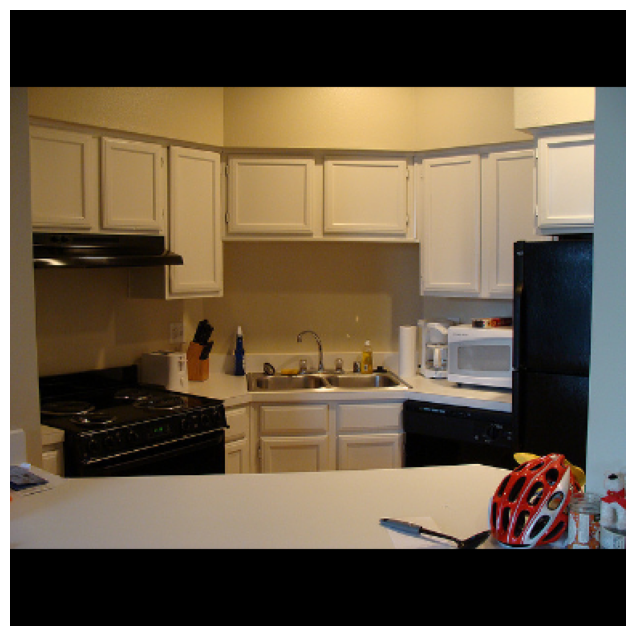

In [4]:
#@title Select an image and run both models on it
image_name = "Kitchen 3" # @param ["Giraffe", "Kitchen", "Kitchen 2", "Kitchen 3", "Two people", "Plane", "Train", "Train 2", "Greyscale traffic light", "Person", "Baseball stadium", "Bus"]

images_for_test_map = {
    "Giraffe": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/1.jpg",
    "Kitchen": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/2.jpg",
    "Kitchen 2": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/8.jpg",
    "Kitchen 3": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/12.jpg",
    "Two people": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/3.jpg",
    "Plane": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/4.jpg",
    "Train": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/5.jpg",
    "Train 2": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/10.jpg",
    "Greyscale traffic light": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/6.jpg",
    "Person": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/7.jpg",
    "Baseball stadium": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/9.jpg",
    "Bus": "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Images/11.jpg"
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, input_size)
show_image(image, '')

model_answer = run_model_on_image(image, model1, classes)

model_answer2 = run_model_on_image(image, model2, classes)

HTML("<h1 style='font-size: 26px; color: blue;'>Answer from Model 1 <br><br><i>" + str(model_answer).replace('\n', '<br>') + "</i></h1> <br>" + "<h1 style='font-size: 26px; color: green;'>Answer from Model 2 <br><br><i> " + str(model_answer2).replace('\n', '<br>') + "</i></h1>")


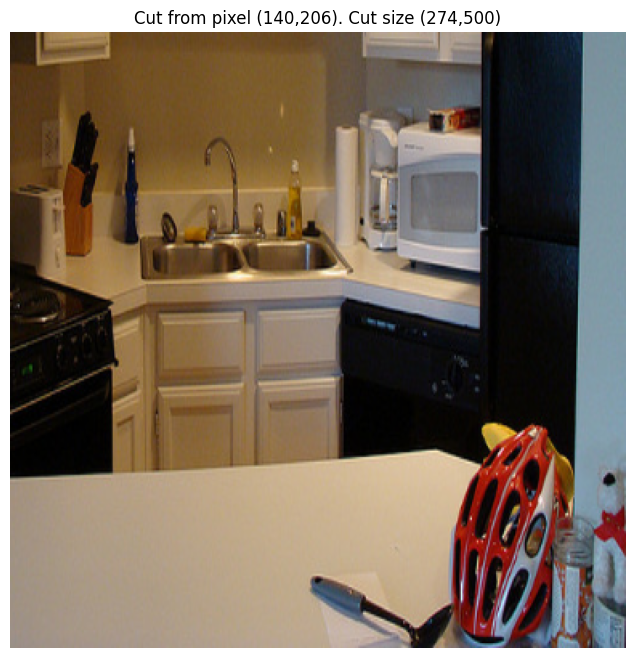

In [5]:
#@title Crop image (from top right corner in %)


x = 22 # @param {type:"slider", min:0, max:100, step:1}
y = 43 # @param {type:"slider", min:0, max:100, step:1}

cut_size_in_pixels = 500 # @param {type:"integer"}

x_cord = int(original_image.shape[2]*x/100)
y_cord = int(original_image.shape[1]*y/100)

image_cut = original_image[:,y_cord:y_cord+cut_size_in_pixels,x_cord:x_cord+cut_size_in_pixels,:]

image = tf.image.resize(image_cut, [input_size, input_size])

show_image(image, f'Cut from pixel ({x_cord},{y_cord}). Cut size ({image_cut.shape[1]},{image_cut.shape[2]})')

model_answer = run_model_on_image(image, model1, classes)
model_answer2 = run_model_on_image(image, model2, classes)

HTML("<h1 style='font-size: 26px; color: blue;'>Answer from Model 1 <br><br><i>" + str(model_answer).replace('\n', '<br>') + "</i></h1> <br>" + "<h1 style='font-size: 26px; color: green;'>Answer from Model 2 <br><br><i> " + str(model_answer2).replace('\n', '<br>') + "</i></h1>")

# Part 2

In [6]:
#@title Helper functions

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

# Adds a bounding box on image
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

# Draws multiple bounding boxes on images (with scores and labels)
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


def run_detector(detector, p_img):
  img = tf.cast(p_img[0] * 255, tf.uint8)
  converted_img  = p_img
  result = detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)

  display_image(image_with_boxes)

  return result

In [8]:
#@title Get object detector
#detector = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures['default']
detector = hub.load("https://www.kaggle.com/models/google/faster-rcnn-inception-resnet-v2/TensorFlow1/faster-rcnn-openimages-v4-inception-resnet-v2/1").signatures["default"]
labels_path_detector = tf.keras.utils.get_file('detector_600_labels.txt','https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv')
classes_detector = np.array(open(labels_path_detector).read().splitlines())

11255/11255 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#@title Run detector on original image
detector_output = run_detector(detector, original_image)

Found 100 objects.


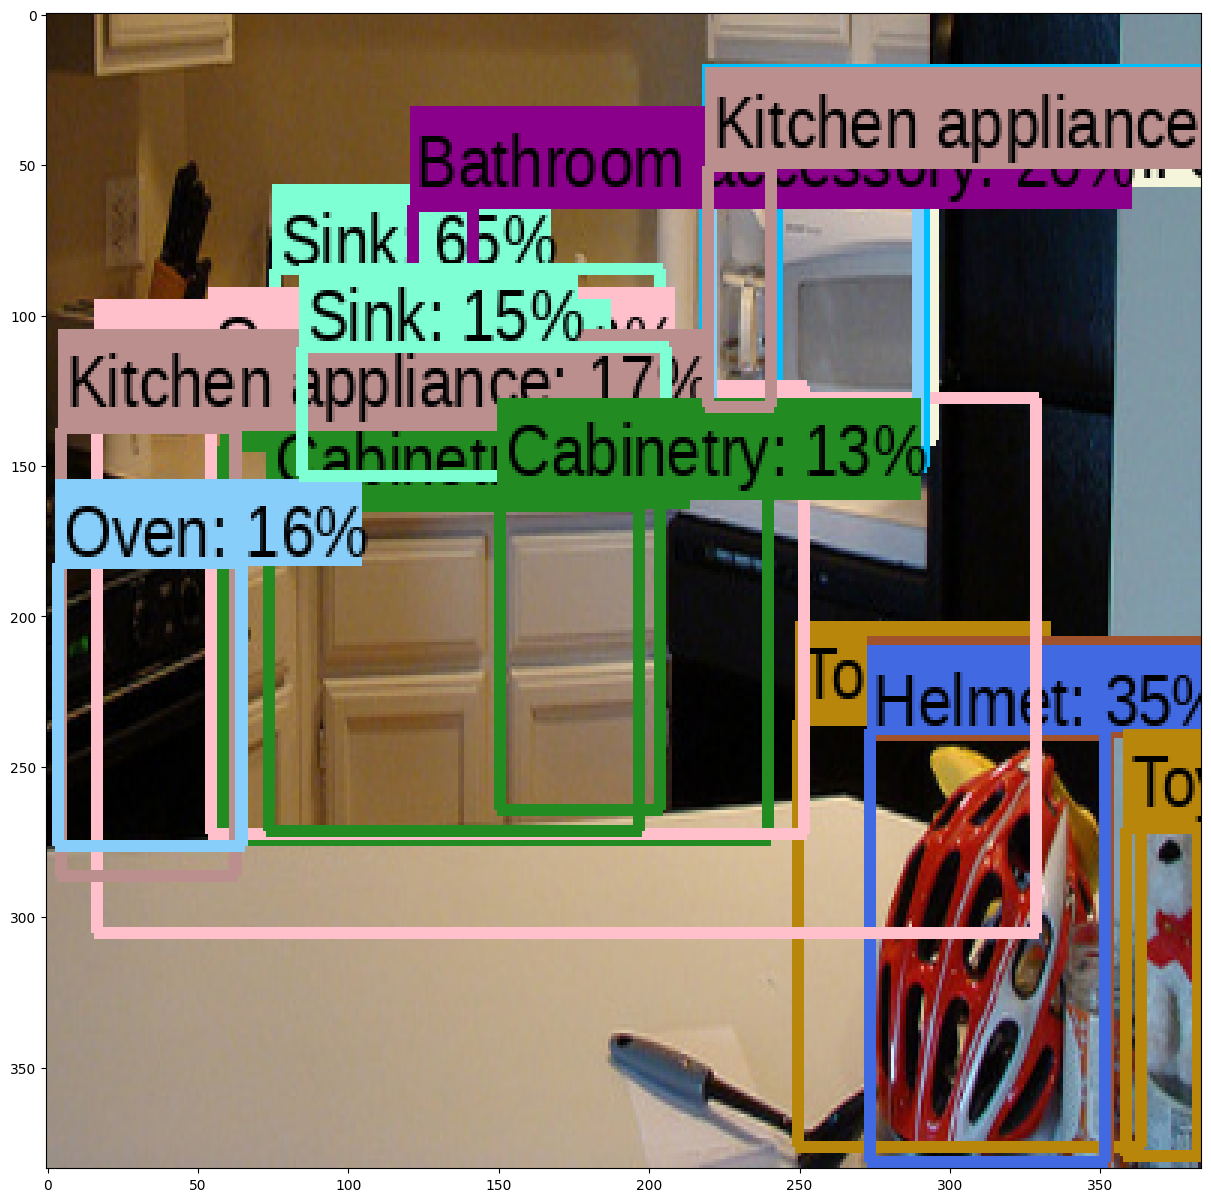

In [ ]:
#@title Run detector on cropped image
detector_output = run_detector(detector, image)

# Part 3

In [ ]:
logging.getLogger('absl').setLevel(logging.ERROR) # Ignore useless warning messages
segmentation_ade20k_model = hub.load('https://tfhub.dev/google/HRNet/ade20k-hrnetv2-w48/1')

In [ ]:
#@title Load in model for segmentation and get classes

segmentation_ade20k_model = hub.load('https://tfhub.dev/google/HRNet/ade20k-hrnetv2-w48/1')
segmentation_labels_path = tf.keras.utils.get_file('ade20k-id2label.json','https://huggingface.co/datasets/huggingface/label-files/raw/main/ade20k-id2label.json')
with open(segmentation_labels_path) as f:
    data = json.load(f)

classes_segmentation = list(data.values())
classes_segmentation = ['background'] + classes_segmentation

2814/2814 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


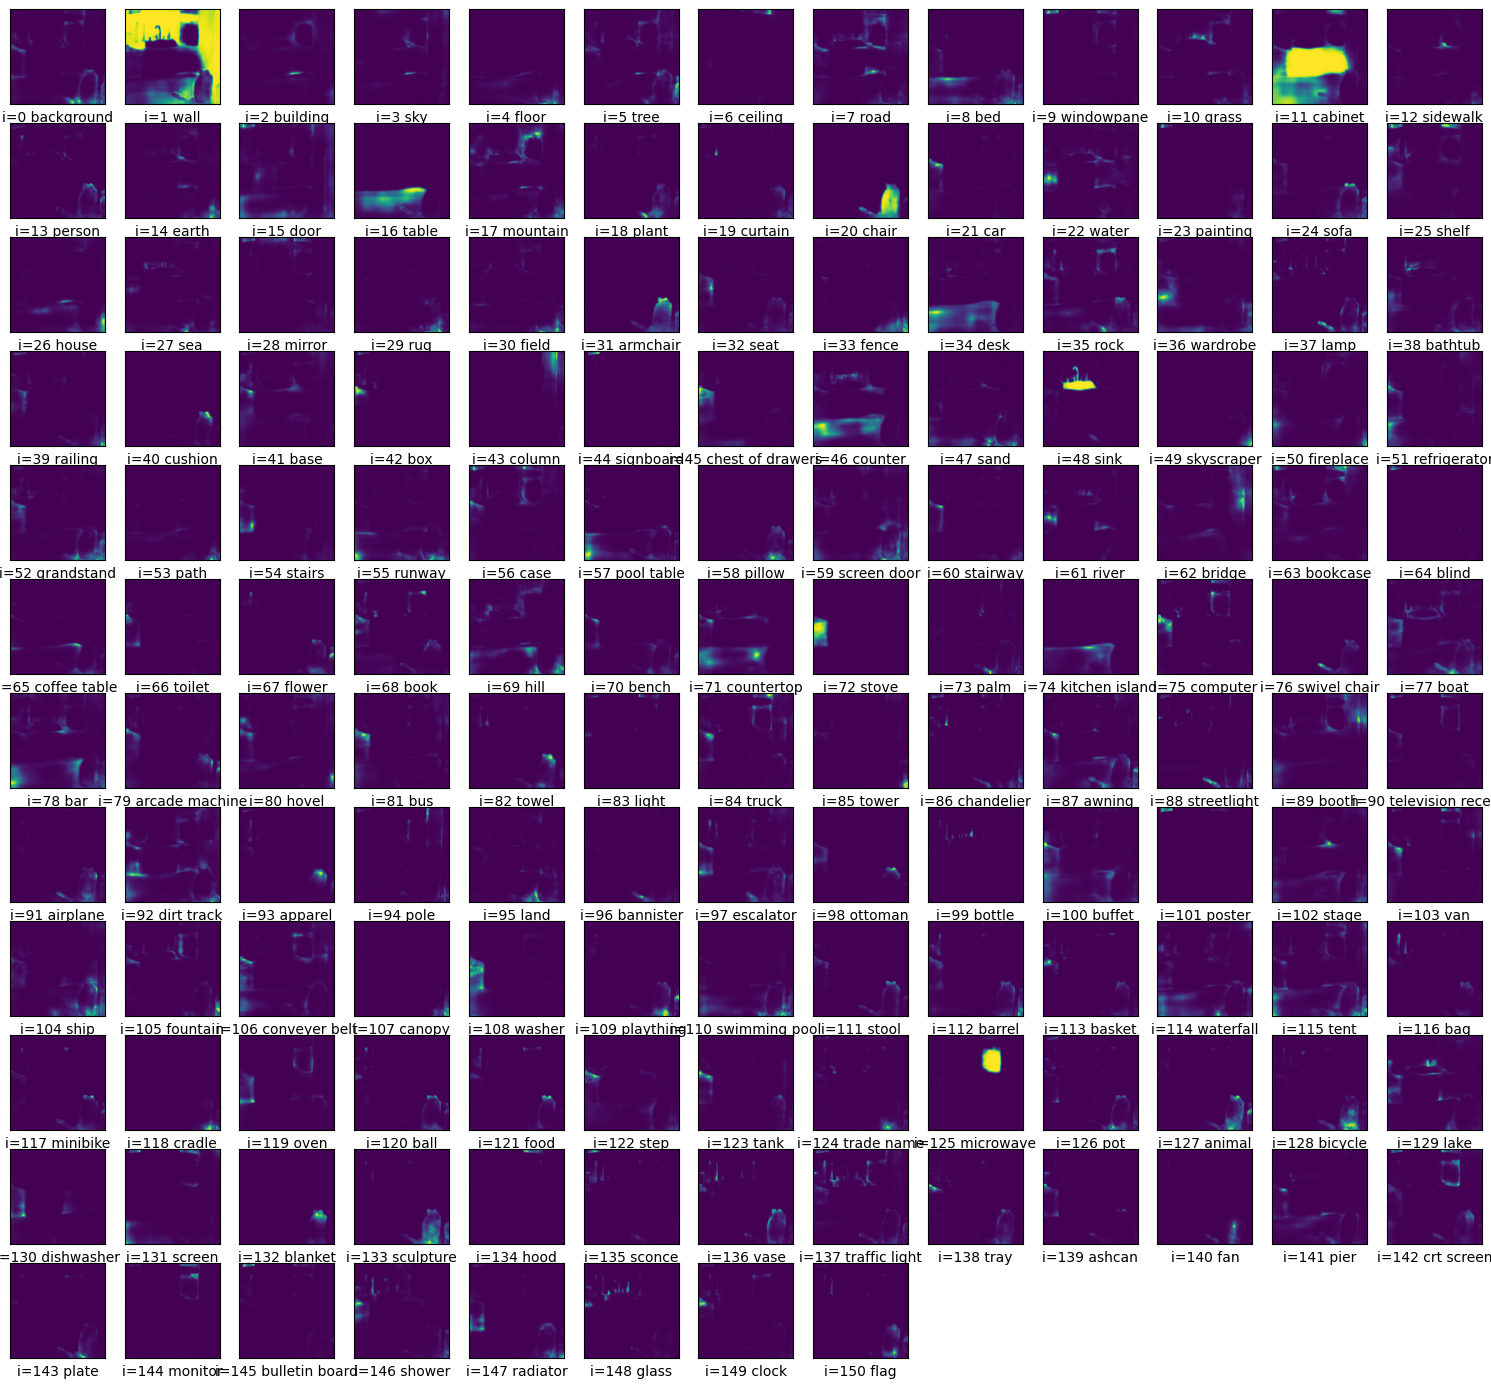

In [ ]:
#@title Get predictions from segmentation model and plot masks
predictions = segmentation_ade20k_model.predict(image) # Predictions will have shape (batch_size, h, w, output_classes=202)
predictions=predictions[0]

number_of_masks = predictions.shape[2]
plot_dim = math.ceil(math.sqrt(number_of_masks))

plt.figure(figsize=(19,19))
for i in range(plot_dim*plot_dim):
    plt.subplot(plot_dim,plot_dim,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions[:,:,i])
    plt.xlabel(f'i={i} {classes_segmentation[i]}')
    if i > number_of_masks-2:
      break
plt.show()

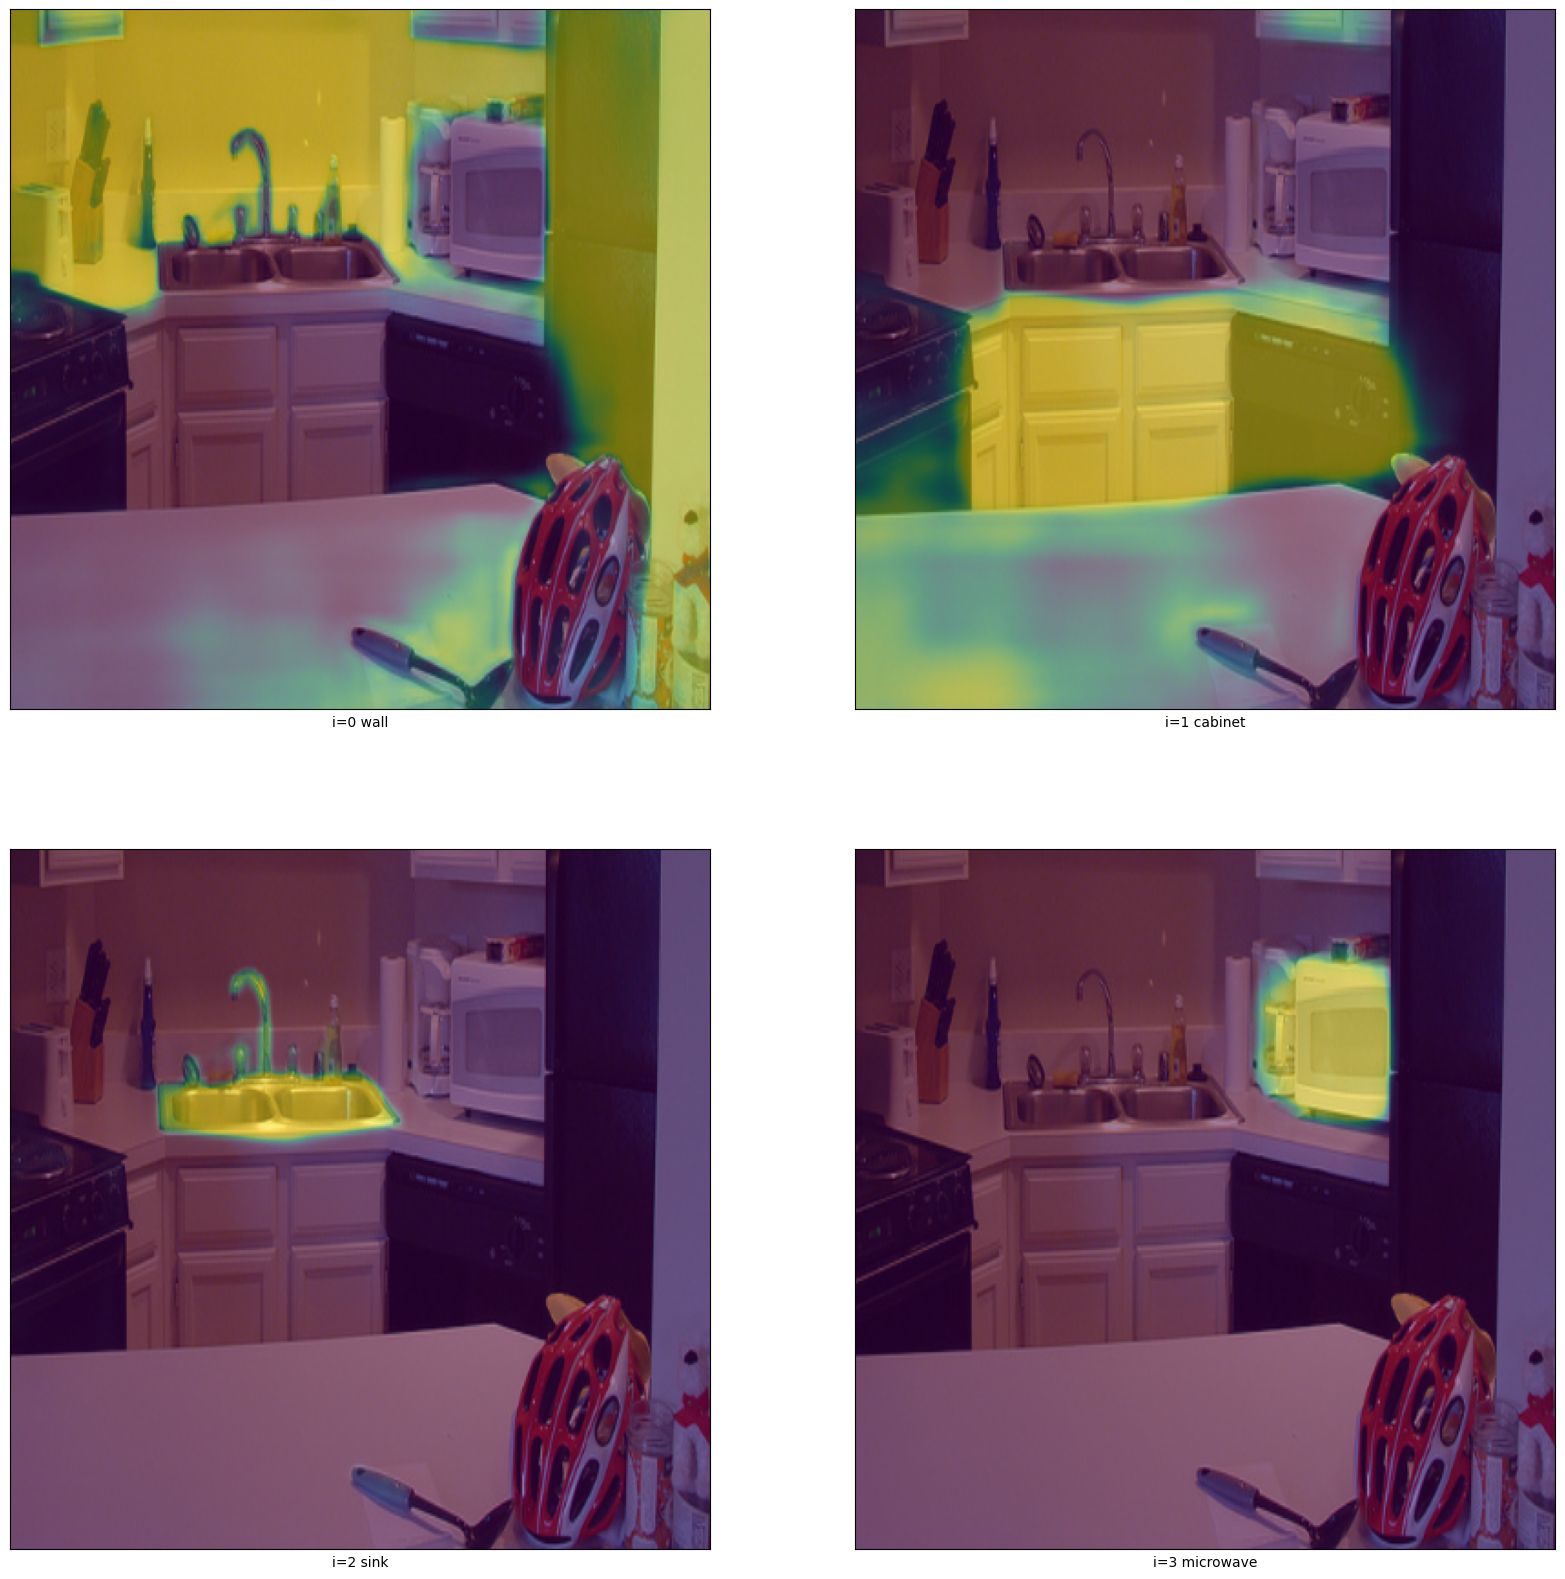

In [ ]:
#@title Pick out relevant masks and plot them over the image
masks = [predictions[:, :, i] for i in [1, 11, 48, 125]]

plt.figure(figsize=(20,20))
for i in range(len(masks)):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0])
    plt.imshow(masks[i], alpha=0.5)
    plt.xlabel(f'i={i} {classes_segmentation[[1, 11, 48, 125][i]]}')
plt.show()